# Smooooooothing

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from odefilter import ivpsolve, recipes

config.update("jax_enable_x64", True)
backend.select("jax")

In [2]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra(time_span=(0.0, 1e-1))


@jax.jit
def vf(t, *ys):
    return f(*ys, *f_args)


num_derivatives = 3

In [3]:
ek0, info_op = recipes.dynamic_isotropic_eks0(num_derivatives=num_derivatives)

In [4]:
ek0sol = ivpsolve.solve(
    vf, initial_values=(u0,), t0=t0, t1=t1, solver=ek0, info_op=info_op
)

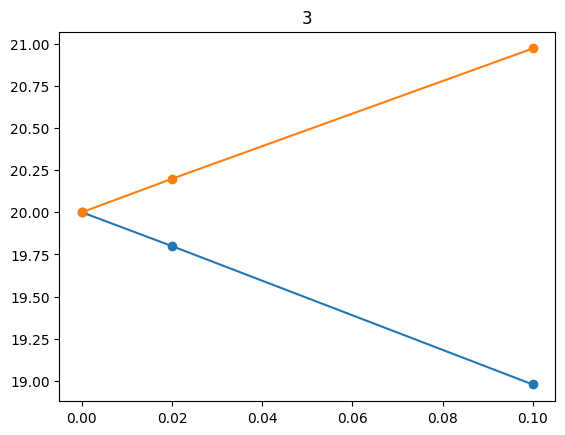

In [5]:
plt.title(len(ek0sol.t))
plt.plot(ek0sol.t, ek0sol.u, "o-")
plt.show()

In [6]:
fixpt_ek0, info_op = recipes.dynamic_isotropic_fixpt_eks0(
    num_derivatives=num_derivatives
)

In [7]:
print()
fixptsol = ivpsolve.simulate_checkpoints(
    vf,
    initial_values=(u0,),
    ts=ek0sol.t,
    solver=fixpt_ek0,
    info_op=info_op,
)
print()

fixptsol2 = ivpsolve.simulate_checkpoints(
    vf,
    initial_values=(u0,),
    ts=jnp.linspace(t0, t1, num=200, endpoint=True),
    solver=fixpt_ek0,
    info_op=info_op,
)
print()

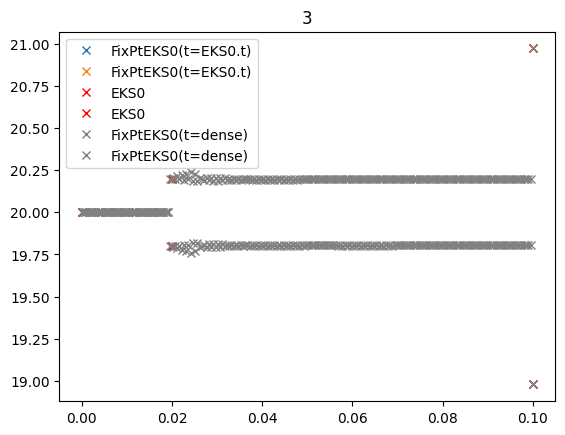

In [8]:
plt.title(len(fixptsol.t))

style = {"linestyle": "None", "marker": "x"}
plt.plot(fixptsol.t, fixptsol.u, **style, label="FixPtEKS0(t=EKS0.t)")
plt.plot(ek0sol.t, ek0sol.u, **style, color="red", linewidth=3, label="EKS0")
plt.plot(fixptsol2.t, fixptsol2.u, **style, color="gray", label="FixPtEKS0(t=dense)")
plt.legend()
# plt.ylim((-20, 30))
plt.show()


# two interpolations in a row are incorrect,
# because they collapse the backward models.
# this is incorrect. The solution is to not
# collapse the backward models if we interpolated twice in a row,
# which is equivalent to

# is the remainder a preconditioning issue? Should be backward-marginalise with a preconditioner?

# what happens if we accept-reject and then overstep very slightly and therefore immediately interpolate?
# Should this be possible?

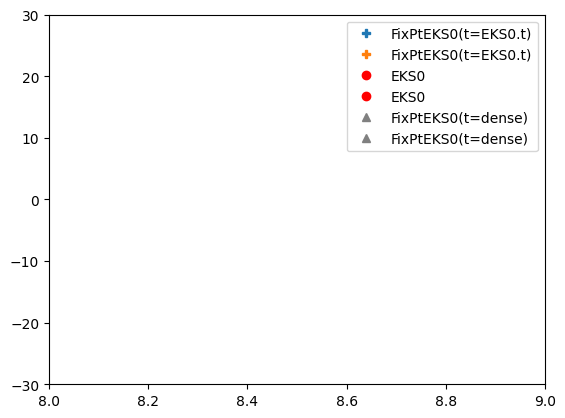

In [9]:
plt.plot(
    fixptsol.t,
    fixptsol.filtered.mean[:, -1, :],
    linestyle="None",
    marker="P",
    label="FixPtEKS0(t=EKS0.t)",
)
plt.plot(
    ek0sol.t,
    ek0sol.filtered.mean[:, -1, :],
    linestyle="None",
    marker="o",
    color="red",
    label="EKS0",
)
plt.plot(
    fixptsol2.t,
    fixptsol2.filtered.mean[:, -1, :],
    linestyle="None",
    marker="^",
    color="gray",
    label="FixPtEKS0(t=dense)",
)
plt.ylim((-30, 30))
plt.xlim((8, 9))
plt.legend()
plt.show()

In [10]:
print(ek0sol.filtered.mean)

[[[ 20.          20.        ]
  [-10.          10.        ]
  [ -5.          -5.        ]
  [ 17.5        -17.5       ]]

 [[ 19.7990234   20.19897673]
  [-10.09648885   9.89651218]
  [ -4.64860625  -5.34847709]
  [ 17.59291689 -17.39847245]]

 [[ 18.97793001  20.97209791]
  [-10.41208002   9.4129589 ]
  [ -3.2411729   -6.74035488]
  [ 17.59291689 -17.39847245]]]


## The final lines should always coincide for:

* t1=1e-2, 1e-1, 1e0, 1e1
* num_derivatives=1, 4, 7
* Denser and coarser evaluation grids than computation grids
* jit and nojit (complete solve)
* f32 and f64


## Make sure that

* The plots only use markers, not lines! (We are comparing checkpoints!)
* The filter solutions are good


## Corner cases for each step


A, A') Attempt-step-loop / no loop

B, B') Stepped exactly to final time / did not

C, C') Overstepped - interpolate / did not



* if A happens, only _either_ B or C or B'&C' can happen
* if A does not happen, B cannot happen; but C must happen because otherwise, nothing happens
* if in the previous step, B happened, A must happen in the next step
* if in the previous step, A-B'-C' happens, A must happen in the next step 

Cases for a single step:

1) A-B'-C'
2) A-B-C'
3) A-B'-C
4) A'-B'-C

Cases for a step-step combination:
1-1,
1-2,
1-3,
2-1,
2-2,
2-3,
3-1,
3-2,
3-3,
3-4,
4-1,
4-2,
4-3,
4-4,

Impossible combinations:
2-4,
1-4,
